## Initalization and Data Loading

In [74]:
# -*- coding: utf-8 -*-

import os
import argparse
import numpy as np
import torch
from torch import nn
from torch import autograd
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from matplotlib import pyplot as plt
from tqdm import tqdm
import scienceplots

In [75]:
# Adding some arguments
parser = argparse.ArgumentParser(description="A pytorch code for learning and testing state space\
                                 trajectory prediction.")

parser.add_argument("--epochs", default=2500, type=int, help="number of epochs for the model to train")
parser.add_argument("--batch_size", default=128, type=int, help="batch size for training of the model")
parser.add_argument("--dt", default=0.005, type=float, help="size of the time step used in the simulation")
parser.add_argument('--train', default=True, action=argparse.BooleanOptionalAction, help="do you wish to train a new model?")
parser.add_argument("--log", default=True, action=argparse.BooleanOptionalAction, help="using log loss for plotting and such")
parser.add_argument("--eps", default=5.0, type=float, help="small epsilon used for weights reparametrization")
parser.add_argument("--lbfgs", default=True, action=argparse.BooleanOptionalAction, help="use lbfgs for optimization")

args, unknown = parser.parse_known_args()

try:
    args = parser.parse_args()
except SystemExit:
    args = parser.parse_args(args=[])

usage: ipykernel_launcher.py [-h] [--epochs EPOCHS] [--batch_size BATCH_SIZE]
                             [--dt DT] [--train | --no-train]
                             [--log | --no-log] [--eps EPS]
                             [--lbfgs | --no-lbfgs]
ipykernel_launcher.py: error: unrecognized arguments: --f=c:\Users\vvvot\AppData\Roaming\jupyter\runtime\kernel-v3de1a9321220a7ef542aa681ad43fab18b74c7f9e.json


In [76]:
# Extracting the data
if os.path.exists("data/dataset.txt") is False:
    raise Exception("We don't have any training data. It should be stored as dataset.txt in the folder data.")

with open("data/dataset.txt", "r", encoding="utf-8") as f:
    data_raw = f.read().strip().split("\n\n")

In [77]:
class TrajectoryDataset(Dataset):
        def __init__(self):
                loaded_trajectories = [
                        [[float(value) for value in line.split(',')] for line in mat_str.strip().split('\n')]
                        for mat_str in data_raw
                    ]
                loaded_trajectories = np.array(loaded_trajectories)
                data = loaded_trajectories[:,1:-2,:]
                target = loaded_trajectories[:,2:-1,:]

                global DIMENSION
                DIMENSION = data.shape[2]-1

                self.position = torch.tensor(data[:,:,1:], requires_grad=True).float()
                self.target_pos = torch.tensor(target[:,:,1:], requires_grad=True).float()
                velocity = (data[:, 2:, 1:] - data[:, :-2, 1:]) / (2 * args.dt)

                # boundary conditions
                velocity_first = (data[:, 1:2, 1:] - data[:, 0:1, 1:]) / args.dt
                velocity_last = (data[:, -1:, 1:] - data[:, -2:-1, 1:]) / args.dt
                velocity = np.concatenate([velocity_first, velocity, velocity_last], axis=1)

                self.velocity = torch.tensor(velocity, requires_grad=True).float()
                self.n_samples = self.position.shape[0]

        def __getitem__(self, index):
            return self.position[index], self.target_pos[index], self.velocity[index] 

        def __len__(self):
            return self.n_samples

trajectories = TrajectoryDataset()

DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

torch.set_default_device(DEVICE)
print(f"Using {DEVICE} for tensor calculations")

generator = torch.Generator(device=DEVICE)
generator.manual_seed(42)

Using cuda for tensor calculations


## Defining the Model

In [78]:
def rk4(f, x, time_step):
    """
        Classical 4th order Runge Kutta implementation
    """
    k1i = f(x)
    k2i = f(x + k1i * time_step/2)
    k3i = f(x + k2i * time_step/2)
    k4i = f(x + k3i * time_step)

    return 1/6 * (k1i + 2*k2i + 2*k3i + k4i)

class PositiveLinear(nn.Linear):
    """
        A positive layer that we use to enforce convexity and concavity
    """

    def forward(self, input):
        W = self.weight
        eps_tensor = torch.tensor(args.eps, device=W.device, dtype=W.dtype)

        positive_W = W + torch.exp(-eps_tensor)
        negative_W = torch.exp(W - eps_tensor) 
        reparam_W = torch.where(W >= 0, positive_W, negative_W) 

        return nn.functional.linear(input, reparam_W, self.bias)
    
stoichiometric_matrix = torch.tensor([
[-1.0,+1.0],
[-2.0,+0.0],
[+1.0,-1.0],
[+0.0,-1.0],], dtype=torch.float32)

In [79]:
class EntropyNetwork(nn.Module):
    """
        For the entropy network we are using a fully input concave neural network achitecture,
        it's a simple alteration of FICNN - fully input convex neural nets
    """
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(DIMENSION, 9)

        self.prop_layer1 = PositiveLinear(9, 9)
        self.lateral_layer1 = nn.Linear(DIMENSION, 9)

        self.prop_layer2 = PositiveLinear(9, 9)
        self.lateral_layer2 = nn.Linear(DIMENSION, 9)

        self.prop_layer3 = PositiveLinear(9, 9)
        self.lateral_layer3 = nn.Linear(DIMENSION, 9)

        self.prop_layer4 = PositiveLinear(9, 9)
        self.lateral_layer4 = nn.Linear(DIMENSION, 9)

        self.output_layer = PositiveLinear(9, 1)
        self.lateral_layer_out = nn.Linear(DIMENSION, 1)

        self._initialize_weights()

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                torch.nn.init.kaiming_normal_(module.weight, generator=generator)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, x0):
        x = nn.Softplus()(self.input_layer(x0))

        x = nn.Softplus()(self.prop_layer1(x) + self.lateral_layer1(x0))

        x = nn.Softplus()(self.prop_layer2(x) + self.lateral_layer2(x0))

        x = nn.Softplus()(self.prop_layer3(x) + self.lateral_layer3(x0))

        x = nn.Softplus()(self.prop_layer4(x) + self.lateral_layer4(x0))

        S_out = nn.Softplus()(self.output_layer(x) + self.lateral_layer_out(x0))

        return -S_out

def dissipation(state, state_conjugate):
    global stoichiometric_matrix
    X = torch.matmul(state_conjugate, -stoichiometric_matrix)

    Xi = 0
    for l in range(stoichiometric_matrix.shape[1]):
        W_l = 1
        for q in range(stoichiometric_matrix.shape[0]):
            W_l *= torch.sqrt((state[...,q]) ** abs(stoichiometric_matrix[q,l]))

        Xi += 4*W_l * (torch.cosh(X[...,l]/2) - 1)

    return Xi

In [80]:
class GradientDynamics(nn.Module):
    def __init__(self):
        super().__init__()
        self.S = EntropyNetwork()
    
    def forward(self, x):
        S = self.S(x)
        x_star = autograd.grad(S, x, grad_outputs=torch.ones_like(S), create_graph=True)[0].float()
        
        Xi = dissipation(x,x_star)
        x_dot = autograd.grad(Xi, x_star, grad_outputs=torch.ones_like(Xi), create_graph=True)[0]

        return x_dot

## Training the Model

In [ ]:
L = nn.MSELoss()

if args.train:
    training_trajectories, test_trajectories = random_split(trajectories, [0.8, 0.2], generator=generator)
    model = GradientDynamics().to(DEVICE)

    lbfgs_dataloader = DataLoader(dataset=training_trajectories, batch_size=args.batch_size, shuffle=True, generator=generator)
    adam_dataloader = DataLoader(dataset=training_trajectories, batch_size=args.batch_size // 2, shuffle=True, generator=generator)

    adam_optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
    lbfgs_optimizer = torch.optim.LBFGS(model.parameters(), lr=1e-1, max_iter=10, history_size=20, line_search_fn='strong_wolfe')

    # Training
    losses = []

    for i in range(args.epochs):
        if i < args.epochs // 2 or not args.lbfgs:
            dataloader = adam_dataloader
            optimizer = adam_optimizer
        else:
            dataloader = lbfgs_dataloader
            optimizer = lbfgs_optimizer

        for j, (pos, targ_pos, veloc) in enumerate(dataloader):
            pos = pos.to(DEVICE)
            targ_pos = targ_pos.to(DEVICE)
            veloc = veloc.to(DEVICE)

            if i < args.epochs // 2 or not args.lbfgs:
                optimizer.zero_grad()
                predicted_veloc = model(pos)
                loss = L(predicted_veloc, veloc)

                loss.backward()
                optimizer.step()

            else:
                def closure():
                    optimizer.zero_grad()
                    predicted_veloc = model(pos)
                    loss = L(predicted_veloc, veloc)

                    loss.backward()
                    return loss

                optimizer.step(closure)

            predicted_veloc = model(pos)
            loss = L(predicted_veloc, veloc)

        if args.log:
            losses.append(np.log(loss.item()))
        else:
            losses.append(loss.item())

        print(f"Epoch no. {i}/{args.epochs} done! Loss: {loss.item()}.", end="\r")

    if os.path.exists("models"):
        torch.save(model.state_dict(), "models/model.pth")
    else:
        os.mkdir("models")
        torch.save(model.state_dict(), "models/model.pth")

else:
    model = GradientDynamics().to(DEVICE)
    model.load_state_dict(torch.load("models/model.pth", weights_only=True))
    model.eval()

if args.train:
    test_pos = trajectories.position[test_trajectories.indices].to(DEVICE)
    test_target_pos = trajectories.target_pos[test_trajectories.indices].to(DEVICE)
    test_vel = trajectories.velocity[test_trajectories.indices].to(DEVICE)


else:
    test_pos = trajectories.position.to(DEVICE)
    test_target_pos = trajectories.target_pos.to(DEVICE)
    test_vel = trajectories.velocity.to(DEVICE)

MSE_loss = L(model(test_pos), test_vel).item()
print(f"Loss on the test set is {MSE_loss}.")

Loss on the test set is 4.697057738667354e-05.676e-05..


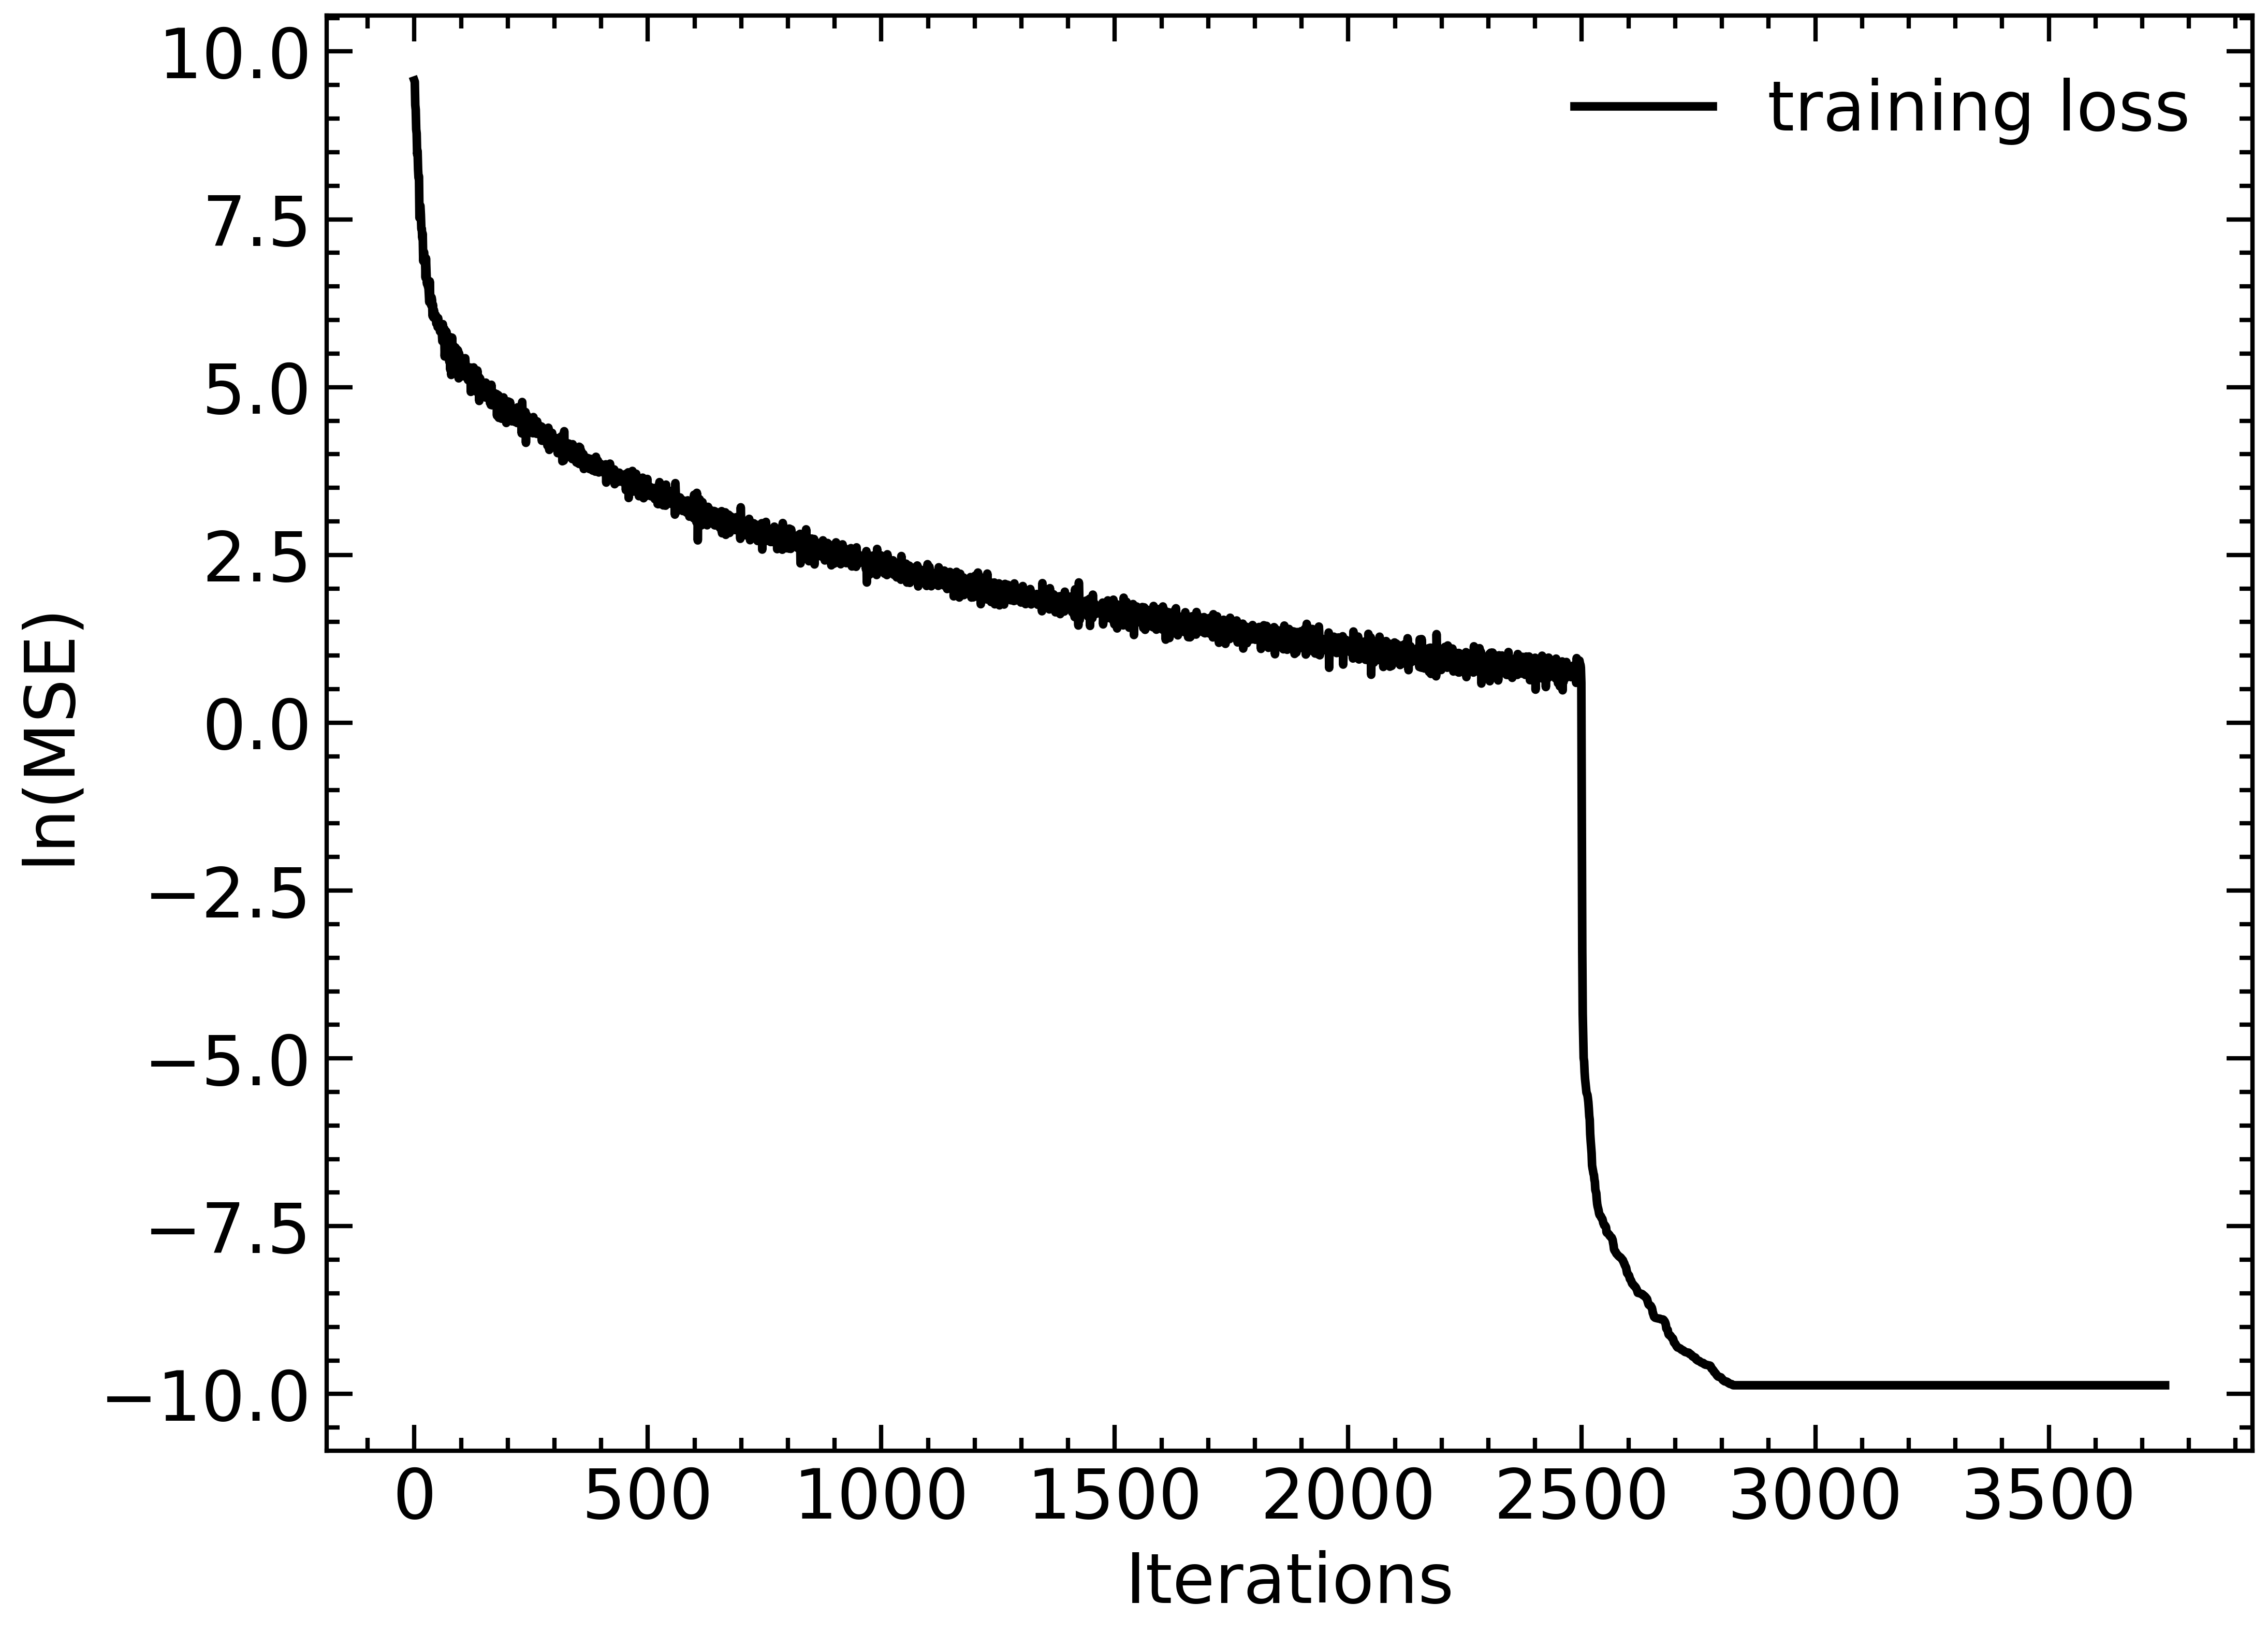

In [82]:
plt.style.use(['science','ieee', 'notebook'])

# Plotting the MSE decline
if args.train:
    fig0,ax0 = plt.subplots()
    ax0.set_xlabel("Iterations")
    if args.log:
        ax0.set_ylabel("ln(MSE)")
    else:
        ax0.set_ylabel("MSE")
    ax0.plot(range(len(losses)), losses, label="training loss")
    ax0.legend()

    fig0.savefig("results/prescribed_dis_training.pdf")

## Plotting Trajectories 

calculating sample trajectory... it shouldn't take too long


100%|██████████| 2045/2045 [00:55<00:00, 37.04it/s]


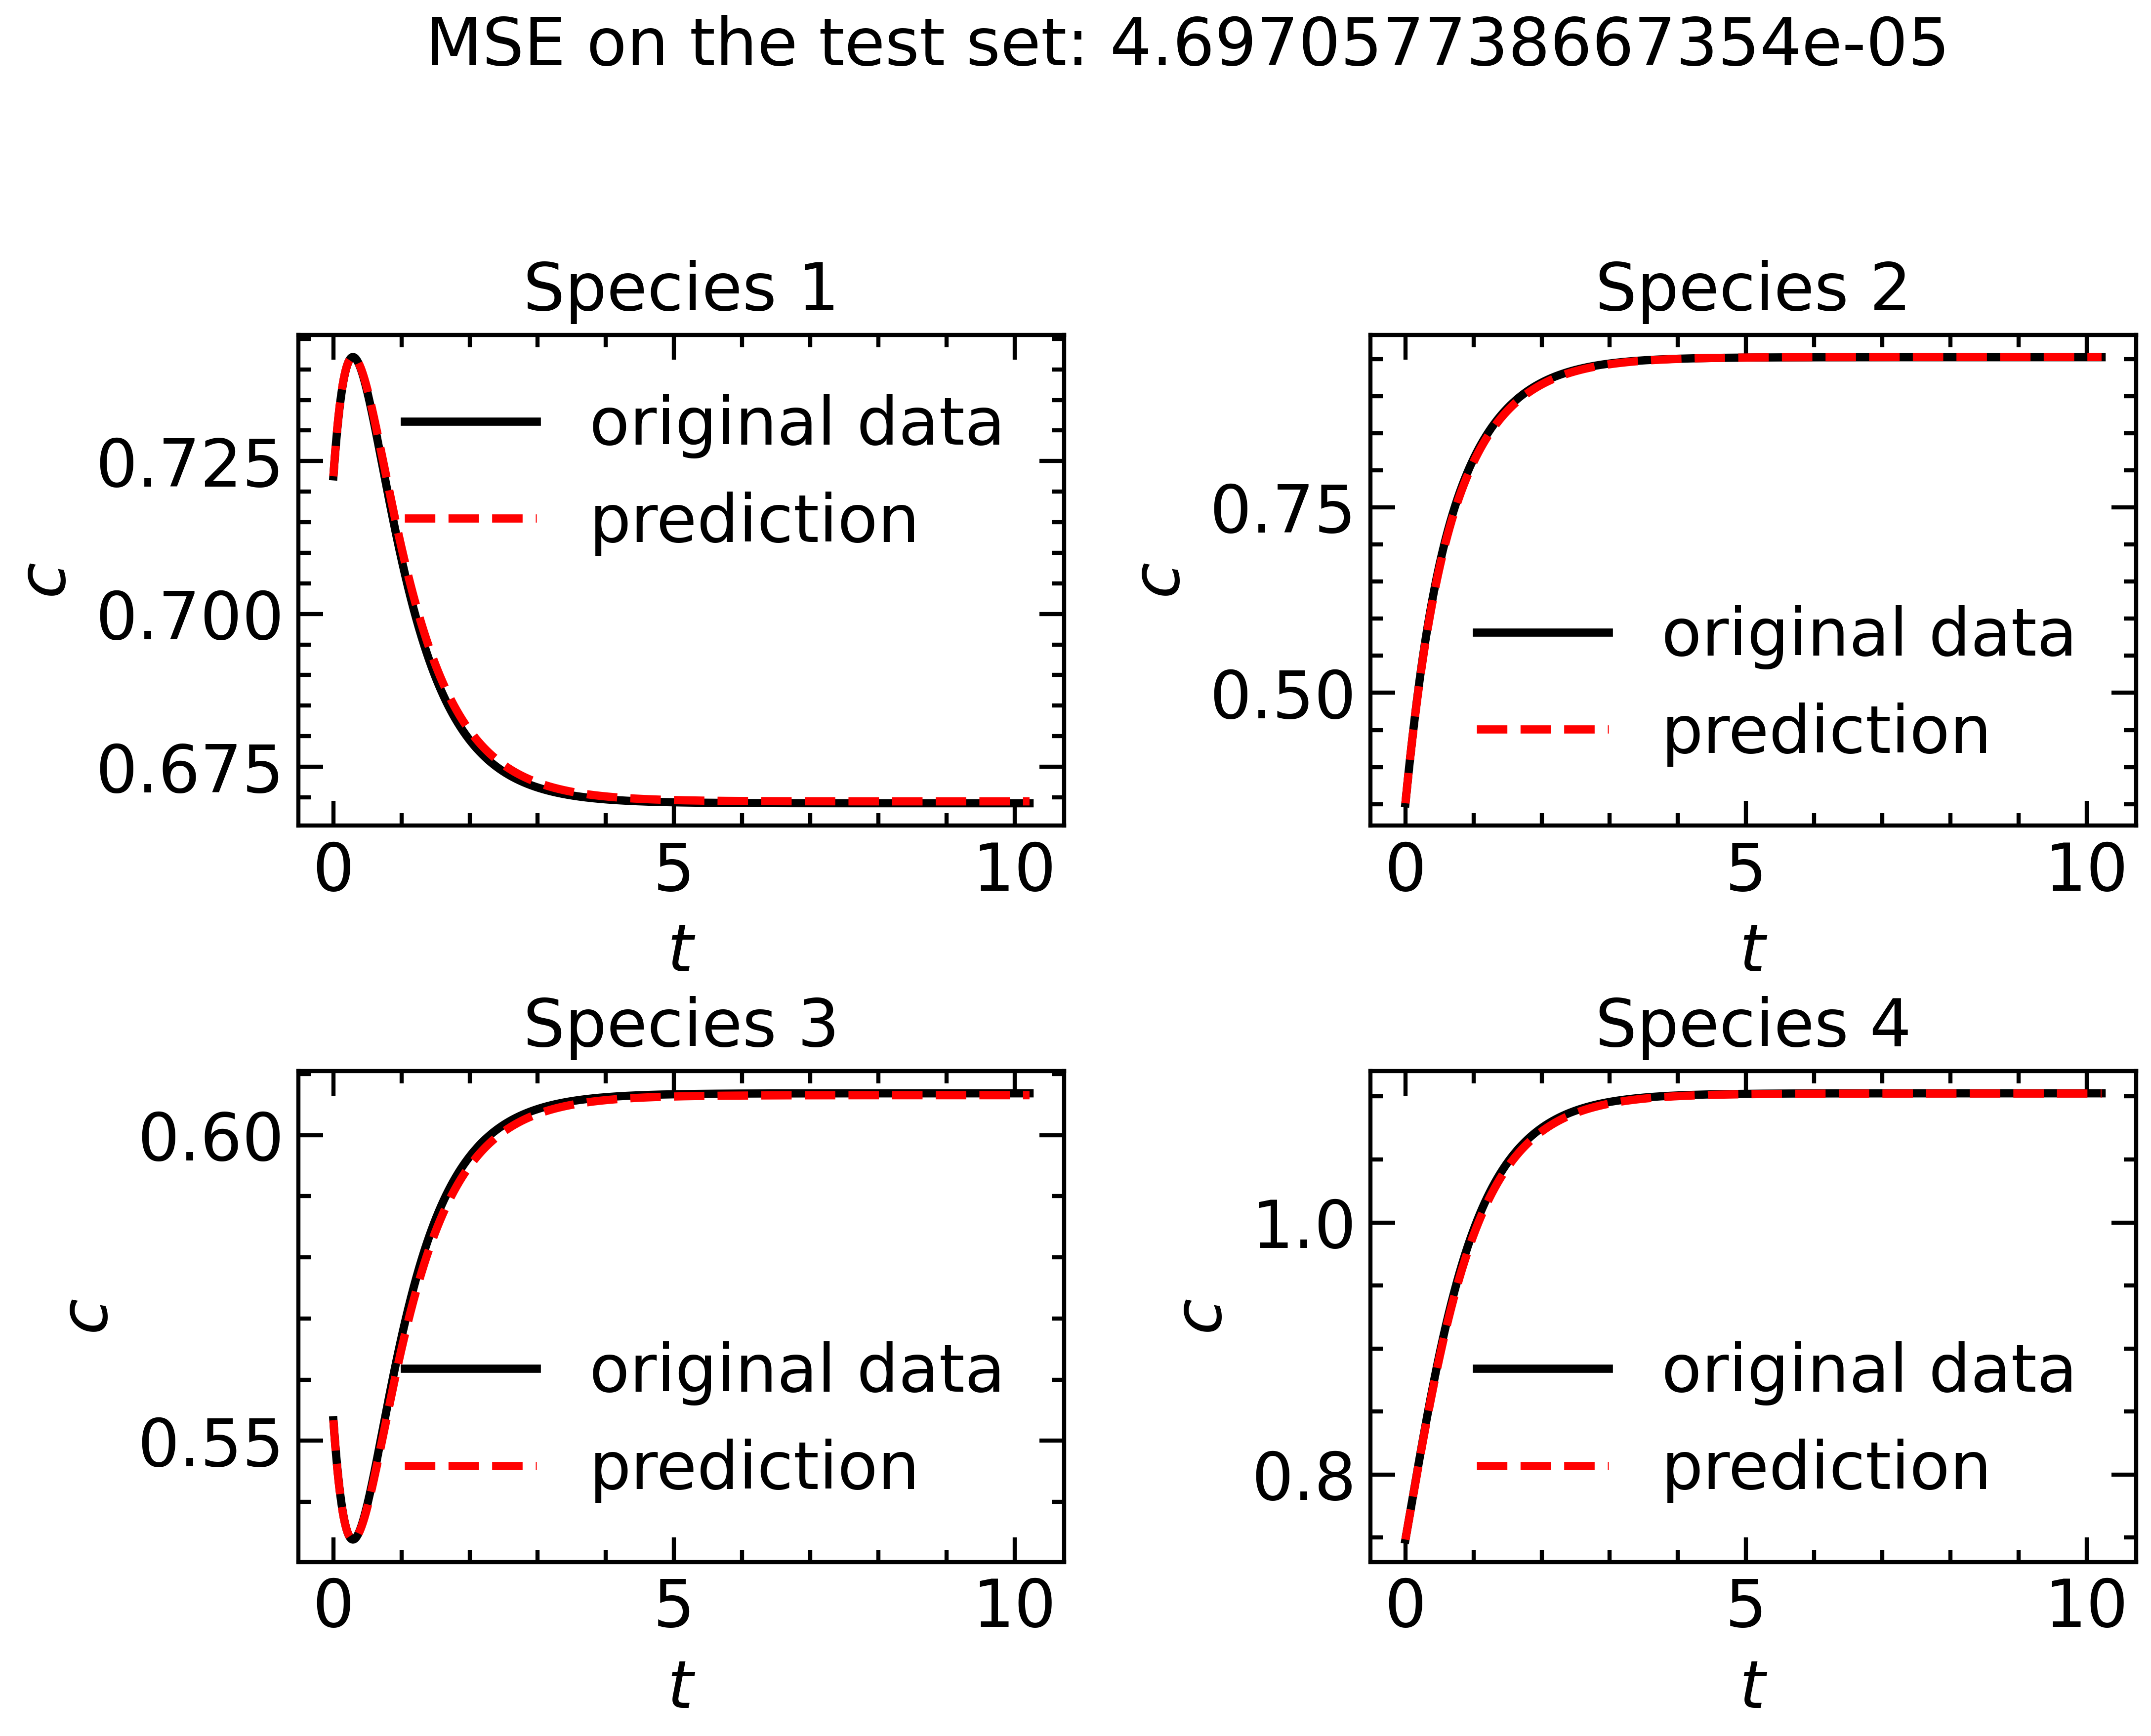

In [ ]:
# Sampling random trajectory and plotting it along with predicted trajectory
fig1, axes1 = plt.subplots(2, int(np.ceil(DIMENSION / 2)))
axes1 = axes1.flatten()

sample = test_pos[np.random.randint(0,len(test_pos)-1)].cpu().detach().numpy()
tensor_sample = torch.tensor([sample], requires_grad=True)
time_set = [args.dt*i for i in range(len(sample))]

prediction = [sample[0]]
print("calculating sample trajectory... it shouldn't take too long")
for i in tqdm(range(len(sample))):
    velocity = rk4(model, torch.tensor(prediction[i], requires_grad=True), args.dt)
    prediction.append(prediction[i] + args.dt * velocity.cpu().detach().numpy())

prediction = np.array(prediction)

fig1.suptitle(f'MSE on the test set: {MSE_loss:.3e}', fontsize=11)

for d in range(DIMENSION):
    graph = axes1[d]

    graph.plot(time_set, sample[:,d], label=r"original data")
    graph.plot(time_set, prediction[:-1,d], label=r"prediction")

    graph.set_title(f"Species {d+1}")
    graph.set_xlabel(r"$t$")
    graph.set_ylabel(r"$c$")
    graph.legend()

fig1.subplots_adjust(wspace=0.4, hspace=0.8,top=0.8)

fig1.savefig("results/prescribed_dis_traj.pdf")

plt.show()

## Plotting the Potentials

In [ ]:
# Plotting entropy
fig4, axes4 = plt.subplots(2, int(np.ceil(DIMENSION / 2)))
axes4 = axes4.flatten()

for d in range(DIMENSION):
    graph = axes4[d]
    x_inputs = torch.full((500, DIMENSION), 0.5, dtype=torch.float32)

    x_independent = torch.linspace(0.0001,1,500, dtype=torch.float32)
    x_inputs[:,d] = x_independent
    x_inputs = torch.tensor(x_inputs, requires_grad=True)

    S_predicted = model.S(x_inputs)
    dS_predicted = autograd.grad(S_predicted, x_inputs, grad_outputs=torch.ones_like(S_predicted), create_graph=True)[0]
    
    S_analytical = torch.sum(-x_inputs*(torch.log(x_inputs) - 1), dim=-1)
    dS_analytical = -torch.log(x_inputs)

    affine_distance = torch.mean(dS_analytical - dS_predicted, dim=0)
    S_predicted_shifted = S_predicted + torch.sum(affine_distance * x_inputs, dim=-1).reshape(-1,1)
    distance = torch.mean(S_analytical - S_predicted_shifted).item()
    
    graph.plot(x_independent.cpu(), S_analytical.cpu().detach().numpy(), label=r"analytical")
    graph.plot(x_independent.cpu(), S_predicted_shifted.cpu().detach().numpy() + distance, label="learned")

    graph.set_xlabel(f"$c_{d+1}$")
    graph.set_ylabel(r"$S$")
    graph.legend()

fig4.subplots_adjust(wspace=0.4, hspace=0.5)

fig4.savefig("results/prescribed_dis_entr.pdf")
plt.show()

NameError: name 'plt' is not defined